# ⚡️Summary ⚡️

In this notebook we look to Tune our selected models, with the features selected in notebook 3

In [1]:
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas as pd 
import numpy as np 

import gc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.metrics import log_loss, mean_squared_error , mean_absolute_error, r2_score
from sklearn.model_selection import KFold,  RepeatedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer

from sklearn.linear_model import Ridge, LinearRegression, HuberRegressor, Lasso,LassoCV,SGDRegressor
from sklearn.svm import SVR

import tensorflow as tf

import optuna
import shap
import lightgbm as lgb
import catboost as cat
import xgboost as xgb
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, GradientBoostingRegressor

In [2]:
#suppress warnings
import warnings
warnings.filterwarnings('ignore')

## Parameters 

In [3]:
target = "Strength" #Target column that we will be predicting, this is here for quick reference 

# Different scaling options
SCALING = False
SCALER = QuantileTransformer(output_distribution = "normal") #RobustScaler()

TEST_ON_GENERATED_ONLY = True
ADD_DATA= True
EPOCHS= 10

OUTLIERS_DROP = False
DROP_GENERATED = False

NUM_FOLDS = 5
NUM_SPLITS = 3

SHAP_VALS = False
CALIBRATION = "linear"

name = 'nn' #LinearRegression rf #ET catboost lightgbm xgboost Gradient, Ridge, SVR ----for LR turn off 'Test_on_Generated'

In [4]:
# Notebook settings
sns.set_style("darkgrid")
pd.set_option('mode.chained_assignment',None)

## 💾 Load Data Data 💾

In [5]:
df_train = pd.read_csv("/kaggle/input/playground-series-s3e9/train.csv", index_col = 0)
df_test = pd.read_csv("/kaggle/input/playground-series-s3e9/test.csv", index_col = 0)
sub = pd.read_csv("/kaggle/input/playground-series-s3e9/sample_submission.csv",index_col = 0)

In [6]:
# if not ADD_DATA:
#     df_train = df_train[df_train['is_generated']==1].drop('is_generated',axis=1)
#     df_test =  df_test[df_test['is_generated']==1].drop('is_generated',axis=1)
# df_train

if ADD_DATA:
    add_data = pd.read_csv('/kaggle/input/predict-concrete-strength/ConcreteStrengthData.csv')
    
    print("length of additional data", len(add_data))
    print("length of original data", len(df_train))
    df_train['is_generated'] = 1
    df_test['is_generated'] = 1
    add_data['is_generated'] = 0
    add_data.columns =df_train.columns

    df_train = pd.concat([df_train, add_data],axis=0, ignore_index=True)
df_train

length of additional data 1030
length of original data 5407


,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength,is_generated
0,525.0,0.0,0.0,186.0,0.0,1125.0,613.0,3,10.38,1
1,143.0,169.0,143.0,191.0,8.0,967.0,643.0,28,23.52,1
2,289.0,134.7,0.0,185.7,0.0,1075.0,795.3,28,36.96,1
3,304.0,76.0,0.0,228.0,0.0,932.0,670.0,365,39.05,1
4,157.0,236.0,0.0,192.0,0.0,935.4,781.2,90,74.19,1
...,...,...,...,...,...,...,...,...,...,...
6432,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28,0
6433,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.18,0
6434,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.70,0
6435,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.77,0


## Helper functions 

In [7]:
def base_model(X_trn,y_trn,X_tst,y_tst, name,model_in, X_in, test_in, print_scores = True):
    
    if name in ["lightgbm"]:
        model_in.fit(X_trn,y_trn,
              eval_set=[(X_tst,y_tst)],
              callbacks= [lgb.log_evaluation(-1), lgb.early_stopping(30)])
        
    elif name in ["xgboost"]:
        model_in.fit(X_trn,y_trn,
                     eval_set=[(X_tst,y_tst)],
                  verbose= 0
                 )
    elif name in ["catboost"]:
        model_in.fit(X_trn,y_trn,
                  eval_set=[(X_tst,y_tst)],
                  early_stopping_rounds=30,
                  verbose= 0
                 )          
    elif name in ["nn"]:
        model_in.compile(loss='mean_squared_error',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.006) 
                 )
        model_in.fit(X_trn,y_trn,epochs=EPOCHS,
                     callbacks=[early_stopping,reduce_lr],
                     validation_data=(X_tst, y_tst), verbose=0)
        
    else:
        model_in.fit(X_trn,y_trn)

    val_preds = model_in.predict(X_tst)
    trn_preds = model_in.predict(X_in)
    test_preds = model_in.predict(test_in)
    
    score_trn =mean_squared_error(y, trn_preds)**0.5
    score_val = mean_squared_error(y_tst, val_preds )**0.5
    
    if print_scores:
        print("\nTrn Score:",score_trn)
        print("Val Score:",score_val)
        #print("Val logloss", log_loss(y,trn_preds_base))
    
    return np.ravel(test_preds), np.ravel(trn_preds), np.ravel(val_preds), score_trn, score_val, model_in

In [8]:
def SMAPE(y_true, y_pred):
    denominator = (y_true + np.abs(y_pred)) / 200.0
    diff = np.abs(y_true - y_pred) / denominator
    diff[denominator == 0] = 0.0
    return np.mean(diff)

In [9]:
def detect_outliers(data):
    outlier_percents = {}
    for column in data.columns:
        q1 = np.quantile(data[column], 0.25)
        q3 = np.quantile(data[column], 0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
        outlier_percent = (outliers.shape[0] / data.shape[0]) * 100
        outlier_percents[column] = outlier_percent
        
    outlier_dataframe = pd.DataFrame(data = outlier_percents.values() ,index=outlier_percents.keys() ,columns=['Outlier_percentage'])
    
    return outlier_dataframe.sort_values(by = 'Outlier_percentage')

In [10]:
class OptimizedEnsemble(object):
    def __init__(self):
        self.coef_ = 0    

    def _rmse_loss(self, coef, X, y):   
        ensemble = np.zeros(len(X))
        for i,col in enumerate(X.columns):
            ensemble = ensemble + coef[i] * X[col] 
        ll = mean_squared_error( y, ensemble )**0.5
        return ll

    def fit(self, X, y):
        loss_partial = partial(self._rmse_loss, X = X, y = y)
        initial_coef = [1/len(X.columns)]*len(X.columns)
        bounds = [(0,None)]* len(X.columns)
        constraints = ({'type': 'eq','fun': lambda w: 1-sum(w)}) #coefs must equal 1 i.e 1-sum(coefs) = 0
        self.coef_ = optimize.minimize(loss_partial, initial_coef,method= 'SLSQP', #'SLSQP','Nelder-Mead'
                                       bounds = bounds,constraints = constraints,
                                      options = {'ftol':1e-10})

    def predict(self, X, coef):
        ensemble = np.zeros(len(X))
        for i,col in enumerate(X.columns):
            ensemble = ensemble + coef[i] * X[col] 
        return ensemble

    def coefficients(self):
        return self.coef_['x']

# 📃 Quick Analysis 📃

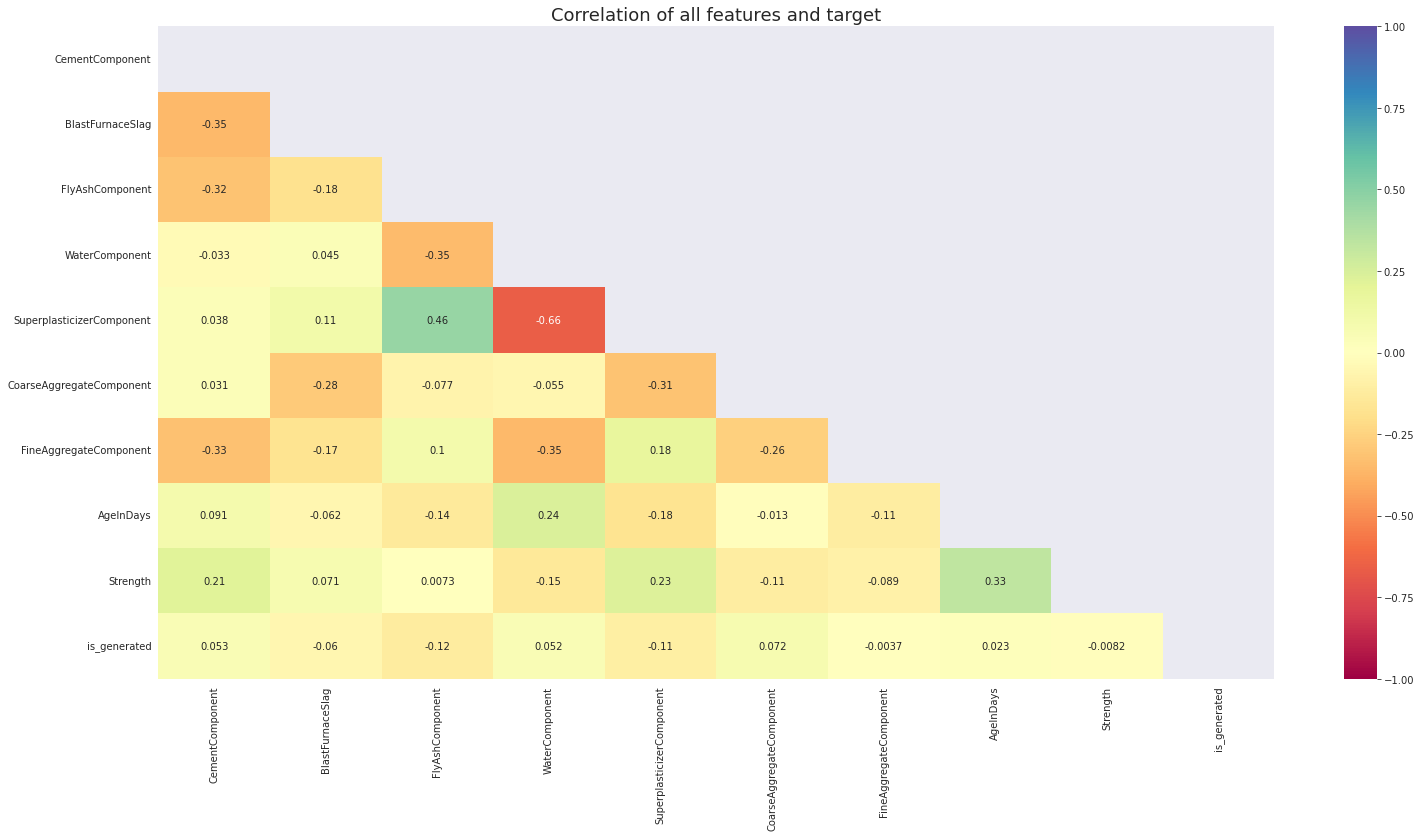

In [11]:
plt.figure(figsize = (25,12))

corr = pd.concat((df_train, df_test), axis =0).corr()
upper_triangle = np.triu(np.ones_like(corr, dtype=bool))

sns.heatmap(corr,vmin = -1, vmax = 1, cmap = "Spectral", annot = True, mask = upper_triangle)
plt.title("Correlation of all features and target", fontsize= 18)
plt.show()

# 🎯 Feature Engineering 🎯
* Here we create features and process our data, by steps that were identified in our EDA

In [12]:
df_trn = df_train.copy(deep = True)
df_tst = df_test.copy(deep = True)
df_trn

,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength,is_generated
0,525.0,0.0,0.0,186.0,0.0,1125.0,613.0,3,10.38,1
1,143.0,169.0,143.0,191.0,8.0,967.0,643.0,28,23.52,1
2,289.0,134.7,0.0,185.7,0.0,1075.0,795.3,28,36.96,1
3,304.0,76.0,0.0,228.0,0.0,932.0,670.0,365,39.05,1
4,157.0,236.0,0.0,192.0,0.0,935.4,781.2,90,74.19,1
...,...,...,...,...,...,...,...,...,...,...
6432,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28,0
6433,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.18,0
6434,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.70,0
6435,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.77,0


### Duplicates 

In [13]:
print("Duplicated rows:",df_trn.duplicated().sum())
print("Duplicated rows, less target:",df_trn.drop(target,axis =1).duplicated().sum())
print("Length of train:",len(df_trn))
print(f"Percentage as duplicates (less target): {df_trn.drop(target,axis =1).duplicated().sum()/len(df_trn)*100:.2f}%" )

Duplicated rows: 25
Duplicated rows, less target: 2439
Length of train: 6437
Percentage as duplicates (less target): 37.89%


In [14]:
print("Duplicated rows TEST:",df_tst.duplicated().sum())
print("Length of TEST:",len(df_tst))
print(f"Percentage as duplicates TEST: {df_tst.duplicated().sum()/len(df_tst)*100:.2f}%" )

Duplicated rows TEST: 1351
Length of TEST: 3605
Percentage as duplicates TEST: 37.48%


Drop actual duplicates (including the target columns in calc)

In [15]:
print("Duplicated including target rows:",df_trn.duplicated().sum())
df_trn.drop_duplicates(inplace = True,ignore_index  = True)
#df_tst.drop_duplicates(inplace = True,ignore_index  = True)
print("final duplicate count:",df_trn.duplicated().sum())

Duplicated including target rows: 25
final duplicate count: 0


* We have a large number of duplicates with differing target values. This is irregular but also logical (i.e. your cement strengh is not always the same) as we may be missing some additonal variables. 
* We therefore want to include these duplicates but help our model file a way to distinguish some middle ground ---lets uses groupby.mean()

Check indexes i.e age groupings are the same in train and test


Int64Index([3, 7, 14, 28, 56, 90, 91, 100, 120, 180, 270, 360, 365], dtype='int64', name='AgeInDays')

Int64Index([1, 3, 7, 14, 28, 56, 90, 91, 100, 120, 180, 270, 360, 365], dtype='int64', name='AgeInDays')

AgeInDays
1       6.270000
3      17.649962
7      22.846047
14     28.512895
28     37.397488
56     54.400392
90     42.285341
91     62.210313
100    49.697733
120    31.537500
180    41.315028
270    49.526250
360    41.737143
365    43.053415
Name: Strength, dtype: float64

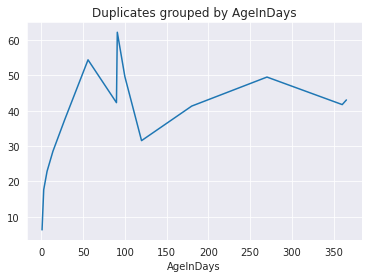

In [16]:
# We find the duplicates in train and groupby (mean) any column (I chose feature "AgeInDays" as this has high feature importance)
Age_grp = df_trn[df_trn.drop(target,axis =1).duplicated()].groupby("AgeInDays").mean()[target]
Age_grp_tst = df_tst[df_tst.duplicated()].groupby("AgeInDays").mean().index
print("Check indexes i.e age groupings are the same in train and test")
display(Age_grp_tst)
display(Age_grp.index)

print("\n")
display(Age_grp)
Age_grp.plot()
plt.title("Duplicates grouped by AgeInDays")
plt.show()

In [17]:
# Bin the values 
for col in df_tst.drop("is_generated",axis =1).columns: 
    grp_target = df_trn[df_trn.drop(target,axis =1).duplicated()].groupby(col).mean()[target]
    
    #create bins
    if 0 in grp_target.index:
        bins = list(grp_target.index)+ [max(df_trn[col])+1]
    else: 
        bins = [0] + list(grp_target.index)
        
    df_trn[f"{col}_grp_mean"] = pd.cut(df_trn[col], bins=bins, labels =grp_target.values )
    df_tst[f"{col}_grp_mean"] = pd.cut(df_tst[col], bins=bins, labels =grp_target.values )
    df_trn[f"{col}_grp_mean"] = df_trn[f"{col}_grp_mean"].astype('float64').fillna(0)
    df_tst[f"{col}_grp_mean"] = df_tst[f"{col}_grp_mean"].astype('float64').fillna(0)
df_tst

,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,is_generated,CementComponent_grp_mean,BlastFurnaceSlag_grp_mean,FlyAshComponent_grp_mean,WaterComponent_grp_mean,SuperplasticizerComponent_grp_mean,CoarseAggregateComponent_grp_mean,FineAggregateComponent_grp_mean,AgeInDays_grp_mean
id,,,,,,,,,,,,,,,,,
5407,166.1,75.4,163.8,173.8,4.6,1007.2,746.6,56,1,27.250000,35.686250,27.25,39.317500,27.250000,53.272500,15.620000,54.400392
5408,304.0,0.0,0.0,190.0,0.0,998.0,801.0,7,1,34.334118,0.000000,0.00,55.562000,0.000000,15.295000,37.165000,22.846047
5409,225.0,0.0,0.0,185.0,0.0,1113.0,833.0,28,1,23.378889,0.000000,0.00,29.399022,0.000000,23.378889,23.378889,37.397488
5410,251.4,0.0,118.3,188.5,6.4,1028.4,757.7,100,1,37.189714,0.000000,33.49,35.751000,33.490000,35.751000,35.751000,49.697733
5411,144.0,15.0,195.0,176.0,6.0,1021.0,709.0,28,1,38.840000,48.400000,65.91,34.505000,38.016071,42.254000,44.691111,37.397488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9007,140.0,129.0,100.0,200.0,7.0,864.0,753.0,28,1,41.053636,15.620000,38.97,34.377111,41.941667,29.930000,42.254000,37.397488
9008,281.0,0.0,0.0,186.0,0.0,1104.0,774.0,28,1,18.954444,0.000000,0.00,36.387000,0.000000,18.954444,25.777273,37.397488
9009,289.0,133.0,0.0,194.0,7.0,924.0,760.0,28,1,29.377143,35.864545,0.00,24.026250,41.941667,47.255000,37.594687,37.397488


### Additional Features

In [18]:
def Additional_Features(df_in):
    df = df_in.copy(deep = True)
    
    # get duplicates df
#     for col in df_test.drop("is_generated",axis =1).columns: 
#         grp_target = df_trn[df_trn.drop(target,axis =1).duplicated()].groupby(col).mean()[target]
#         if 0 in grp_target.index:
#             bins = list(grp_target.index)+ [max(df_trn[col])+1]
#         else: 
#             bins = [0] + list(grp_target.index)
        
#         #add cols by Bins
#         df[f"{col}_grp_mean"] = pd.cut(df[col], bins=bins, labels =grp_target.values )
#         df[f"{col}_grp_mean"] = df[f"{col}_grp_mean"].astype('float64').fillna(0)

    return df

df_trn = Additional_Features(df_trn)
df_tst = Additional_Features(df_tst)
df_trn

,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength,is_generated,CementComponent_grp_mean,BlastFurnaceSlag_grp_mean,FlyAshComponent_grp_mean,WaterComponent_grp_mean,SuperplasticizerComponent_grp_mean,CoarseAggregateComponent_grp_mean,FineAggregateComponent_grp_mean,AgeInDays_grp_mean
0,525.0,0.0,0.0,186.0,0.0,1125.0,613.0,3,10.38,1,39.276327,0.000000,0.000,36.387000,0.000000,36.985248,37.088376,17.649962
1,143.0,169.0,143.0,191.0,8.0,967.0,643.0,28,23.52,1,38.840000,37.260000,36.955,35.975000,50.408333,44.691111,55.160000,37.397488
2,289.0,134.7,0.0,185.7,0.0,1075.0,795.3,28,36.96,1,29.377143,27.623226,0.000,32.085729,0.000000,37.340000,30.250000,37.397488
3,304.0,76.0,0.0,228.0,0.0,932.0,670.0,365,39.05,1,34.334118,50.408333,0.000,41.083709,0.000000,40.688405,38.541071,43.053415
4,157.0,236.0,0.0,192.0,0.0,935.4,781.2,90,74.19,1,38.504211,38.965000,0.000,30.644892,0.000000,38.808889,38.808889,42.285341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6407,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28,0,35.975000,33.418182,43.590,61.865000,33.856667,29.930000,35.797500,37.397488
6408,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.18,0,27.150000,0.000000,45.294,31.900000,27.150000,37.360000,48.280000,37.397488
6409,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.70,0,65.910000,56.480000,48.280,39.108000,44.650000,55.640000,29.440000,37.397488
6410,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.77,0,19.690000,45.910000,0.000,34.505000,38.300000,34.505000,33.200385,37.397488


### Drop Cols 
Below we will create sets of columns to drop/ keep for each model. These columns will be identified by trial and error as well as well as Recursive Feature Engineering 

In [19]:
all_drop_cols = []

#keep these 
cat_cols = ['CementComponent', 'BlastFurnaceSlag', 'WaterComponent', 'SuperplasticizerComponent', 'FineAggregateComponent', 'AgeInDays', 'is_generated', 'CementComponent_grp_mean', 'WaterComponent_grp_mean', 'CoarseAggregateComponent_grp_mean', 'FineAggregateComponent_grp_mean', 'AgeInDays_grp_mean']
lgb_cols =[col for col in df_trn.columns if col not in [target]]
xgb_cols = ["is_generated",'CementComponent', 'SuperplasticizerComponent', 'AgeInDays', 'CementComponent_grp_mean', 'FlyAshComponent_grp_mean', 'WaterComponent_grp_mean', 'AgeInDays_grp_mean']
rf_cols = ['CementComponent', 'BlastFurnaceSlag', 'WaterComponent', 'SuperplasticizerComponent', 'CoarseAggregateComponent', 'FineAggregateComponent', 'AgeInDays', 'is_generated', 'CementComponent_grp_mean', 'BlastFurnaceSlag_grp_mean', 'WaterComponent_grp_mean', 'CoarseAggregateComponent_grp_mean', 'FineAggregateComponent_grp_mean', 'AgeInDays_grp_mean']
GR_cols = ['CementComponent', 'BlastFurnaceSlag', 'WaterComponent', 'SuperplasticizerComponent', 'CoarseAggregateComponent', 'FineAggregateComponent', 'AgeInDays', 'is_generated', 'CementComponent_grp_mean', 'WaterComponent_grp_mean', 'CoarseAggregateComponent_grp_mean', 'AgeInDays_grp_mean']
ET_cols = ['CementComponent', 'BlastFurnaceSlag', 'FlyAshComponent', 'WaterComponent', 'SuperplasticizerComponent', 'CoarseAggregateComponent', 'FineAggregateComponent', 'AgeInDays', 'is_generated', 'CementComponent_grp_mean', 'BlastFurnaceSlag_grp_mean', 'WaterComponent_grp_mean', 'SuperplasticizerComponent_grp_mean', 'CoarseAggregateComponent_grp_mean', 'FineAggregateComponent_grp_mean', 'AgeInDays_grp_mean']
lin_cols = ['CementComponent', 'BlastFurnaceSlag', 'FlyAshComponent', 'WaterComponent', 'SuperplasticizerComponent', 'AgeInDays', 'is_generated', 'CementComponent_grp_mean', 'BlastFurnaceSlag_grp_mean', 'FlyAshComponent_grp_mean', 'WaterComponent_grp_mean', 'SuperplasticizerComponent_grp_mean', 'CoarseAggregateComponent_grp_mean', 'FineAggregateComponent_grp_mean', 'AgeInDays_grp_mean']

In [20]:
if name == "xgboost":
        
    df_trn = df_trn[xgb_cols+[target]]
    df_tst = df_tst[xgb_cols]
    
if name == "ET":
        
    df_trn = df_trn[ET_cols+[target]]
    df_tst = df_tst[ET_cols]
                
elif name == "lightgbm":

    df_trn = df_trn[lgb_cols+[target]]
    df_tst = df_tst[lgb_cols]

elif name in ["rf"]:
    df_trn.drop(all_drop_cols, axis =1, inplace = True)
    df_tst.drop(all_drop_cols, axis =1, inplace = True)
    
elif name in ["catboost"]:
        
        df_trn = df_trn[cat_cols+[target]]
        df_tst = df_tst[cat_cols]
        
if name == "Gradient":
        
    df_trn = df_trn[GR_cols+[target]]
    df_tst = df_tst[GR_cols]
        
elif name in ["LinearRegression",'Ridge', "SVR"]:
    df_trn = df_trn[lin_cols+[target]]
    df_tst = df_tst[lin_cols]

In [21]:
print([col for col in df_trn.columns])

['CementComponent', 'BlastFurnaceSlag', 'FlyAshComponent', 'WaterComponent', 'SuperplasticizerComponent', 'CoarseAggregateComponent', 'FineAggregateComponent', 'AgeInDays', 'Strength', 'is_generated', 'CementComponent_grp_mean', 'BlastFurnaceSlag_grp_mean', 'FlyAshComponent_grp_mean', 'WaterComponent_grp_mean', 'SuperplasticizerComponent_grp_mean', 'CoarseAggregateComponent_grp_mean', 'FineAggregateComponent_grp_mean', 'AgeInDays_grp_mean']


### Inf and nan values
Check to see if we have any Nan or infinte values 

In [22]:
print(np.isinf(df_trn).sum().sum())#.sort_values(ascending = False))
print(np.isnan(df_trn).sum().sum()) #.sort_values(ascending = False))

0
0


### Outliers
NB for linear regression 

In [23]:
# from IPython.display import display_html 

# df1_styler = detect_outliers(df_trn).style.set_table_attributes("style='display:inline'").set_caption('Train')
# df2_styler = detect_outliers(df_tst).style.set_table_attributes("style='display:inline'").set_caption('Test')

# #display_html(df1_styler._repr_html_()+df2_styler._repr_html_(), raw=True)
# display_html(df1_styler._repr_html_()+df2_styler._repr_html_(), raw=True)

In [24]:
def outlier_removal(data , i):
    q1 = np.quantile(data[i] ,0.25)
    q3 = np.quantile(data[i] , 0.75)
    iqr = q3-q1
    lower_tail = q1 - 1.5*iqr
    upper_tail = q3 + 1.5*iqr
    data.drop(data[data[i]> upper_tail].index , inplace = True)
    data.drop(data[data[i]< lower_tail].index ,inplace =True)
    
if OUTLIERS_DROP:
    outlier_list = ['made']
    for  i in outlier_list:
        outlier_removal(df_train ,i)

# 🧫 PCA Implementation 🧫
* We can also create features using PCA and Kmeans Clustering. However this can cause overfitting 
* Another purpose of PCA is to remove correlation in our data. This will help stop our model from overfitting however there can be data loss during the process 

#### NOTE: PCA is best to use cautiously as it can worsen your models performance 

In [25]:
PCA_ON= False
if PCA_ON:
    c = pd.concat([df_trn.drop(target,axis =1), df_tst]).corr().abs()
    #np.fill_diagonal(c.values, 0)
    trimask = np.triu(np.ones_like(c, dtype=bool))
    c= c.mask(trimask)
    s = c.unstack()
    so = s.sort_values(ascending=False)

    so[(so>0.5) |(so<-0.5)].head(10)

In [26]:
if PCA_ON:
    from sklearn.decomposition import PCA  

    pca_cols = ["sym_1", "squareMeters"]
    pca = PCA(n_components=1 ,whiten=True)
    df_trn_pca = pca.fit_transform(df_trn[pca_cols])
    df_tst_pca = pca.transform(df_tst[pca_cols])


    df_trn["PCA1"] = df_trn_pca
    df_tst["PCA1"] = df_tst_pca
    df_trn.drop(pca_cols,axis =1,inplace = True)
    df_tst.drop(pca_cols,axis =1,inplace = True)
df_trn

,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength,is_generated,CementComponent_grp_mean,BlastFurnaceSlag_grp_mean,FlyAshComponent_grp_mean,WaterComponent_grp_mean,SuperplasticizerComponent_grp_mean,CoarseAggregateComponent_grp_mean,FineAggregateComponent_grp_mean,AgeInDays_grp_mean
0,525.0,0.0,0.0,186.0,0.0,1125.0,613.0,3,10.38,1,39.276327,0.000000,0.000,36.387000,0.000000,36.985248,37.088376,17.649962
1,143.0,169.0,143.0,191.0,8.0,967.0,643.0,28,23.52,1,38.840000,37.260000,36.955,35.975000,50.408333,44.691111,55.160000,37.397488
2,289.0,134.7,0.0,185.7,0.0,1075.0,795.3,28,36.96,1,29.377143,27.623226,0.000,32.085729,0.000000,37.340000,30.250000,37.397488
3,304.0,76.0,0.0,228.0,0.0,932.0,670.0,365,39.05,1,34.334118,50.408333,0.000,41.083709,0.000000,40.688405,38.541071,43.053415
4,157.0,236.0,0.0,192.0,0.0,935.4,781.2,90,74.19,1,38.504211,38.965000,0.000,30.644892,0.000000,38.808889,38.808889,42.285341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6407,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28,0,35.975000,33.418182,43.590,61.865000,33.856667,29.930000,35.797500,37.397488
6408,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.18,0,27.150000,0.000000,45.294,31.900000,27.150000,37.360000,48.280000,37.397488
6409,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.70,0,65.910000,56.480000,48.280,39.108000,44.650000,55.640000,29.440000,37.397488
6410,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.77,0,19.690000,45.910000,0.000,34.505000,38.300000,34.505000,33.200385,37.397488


# 🔬 OPTUNA 🔬


In [27]:
if TEST_ON_GENERATED_ONLY:
    X = df_trn.drop(target,axis =1)
    y= df_trn[target]
    X_validation = df_trn["is_generated"]==1

else: 
    X = df_trn.drop([target],axis =1)
    y= df_trn[target]

In [28]:
if DROP_GENERATED:
    X = df_trn.drop("is_generated",axis =1)
    df_tst = df_tst.drop("is_generated",axis =1)

In [29]:
def objective(trial,X=X,y=y):
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15,random_state=42)
    param = {
        'booster' : 'gbtree', #, gblinear dart gbtree
        'tree_method':'hist',  #gpu_hist
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        'learning_rate': trial.suggest_categorical('learning_rate', [0.008,0.01,0.012,0.014,0.016,0.018, 0.02]),
        'max_depth': trial.suggest_categorical('max_depth', [5,7,9,11,13,15,17]),
        'random_state': trial.suggest_categorical('random_state', [1,2,3,4,5]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
        'objective' : "reg:squarederror",
        'n_estimators' : EPOCHS, 
        'early_stopping_rounds' :30,
    }
    model = xgb.XGBRegressor(**param)  
    
    test_preds_fold, trn_preds_fold, val_preds_fold, score_train_fold, score_val_fold , model_out= base_model(X_train,y_train,X_test,y_test, name,model, X, df_tst, False)
    
    return score_val_fold

In [30]:
OPTUNA = False
if OPTUNA:
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=30)
    print('Number of finished trials:', len(study.trials))
    Best_params = study.best_trial.params
    
    print('Best trial:', Best_params)

In [31]:
lgb_params ={'objective': 'regression',# regression_l1, huber, fair, poisson, quantile, mape, gamma, tweedie
             "metric":"rmse", 
             "boosting_type": "gbdt",#"dart",gbdt
             'reg_alpha': 1, 
#              'lambda_l2': 9.938606206413121,
#              'num_leaves': 44,
              'colsample_bytree': 0.8,
#               'subsample': 0.8,
#             'bagging_freq': 6,
#              'min_data_in_leaf': 134,
#              'min_child_samples': 70,
#              'max_depth': 9,   
             'n_estimators':EPOCHS,
             'learning_rate':0.1,
            'device':'cpu'}

xgb_params = { 
    'objective' : "reg:squarederror",
    'n_estimators' : EPOCHS, 
    'early_stopping_rounds' :30,
    'eval_metric' : "rmse",
    'learning_rate': 0.55,
    #'max_depth': 5,
    'booster' : 'gbtree'#'gbtree',dart
             }
cat_params = {'iterations':EPOCHS,
              'eval_metric' : "RMSE", 
              'learning_rate': 0.08,
              'loss_function':'RMSE',
              "depth" : 6,
              "l2_leaf_reg": 9,
              'random_strength': 1,
              #"bagging_temperature": 500,
              "grow_policy":"SymmetricTree" #"Depthwise"
             }

ET_params = {'max_depth':10, 'n_estimators':EPOCHS, #'max_features' :'sqrt', #log2 None
             #'bootstrap':False
            }
RF_params = { 'max_depth':7,'n_estimators':EPOCHS,
            }

GR_params = {'loss':'squared_error',
    'learning_rate':0.008,
    'n_estimators':EPOCHS,
    'subsample':1.0,
    'criterion':'friedman_mse',# squared_error
    'min_samples_split':2,
    'min_samples_leaf':1,
    'min_weight_fraction_leaf':0.0,
    'max_depth':3,
    'min_impurity_decrease':0.0,
    'max_features':None,
    #'alpha':0.9,
    'verbose':0,
    'max_leaf_nodes':None,
    'warm_start':False,
    #'validation_fraction':0.1,
    'n_iter_no_change':None,
    'tol':0.0001,
    'ccp_alpha':0.0}

In [32]:
if OPTUNA and name =="xgboost":
    xgb_params.update(Best_params)

# 🦠 Cross Validation 🦠

In [33]:
kfold = RepeatedKFold(n_splits=NUM_FOLDS, n_repeats=NUM_SPLITS, random_state=200) #42
 
if name =="xgboost":
    model= xgb.XGBRegressor(**xgb_params)
elif name =="lightgbm":
    model= lgb.LGBMRegressor(**lgb_params)
elif name == "rf":
    model = RandomForestRegressor(**RF_params)
elif name == "catboost":
    model = cat.CatBoostRegressor(**cat_params)
if name == "LinearRegression":
    model = LinearRegression()
if name == "ET":
    model =ExtraTreesRegressor(**ET_params)
if name == "SVR":    
     model =SVR( kernel = "rbf",max_iter = EPOCHS+2000) #linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’
if name == "Ridge":    
     model = Ridge(alpha=430,max_iter = EPOCHS)
if name == "Gradient":    
     model = GradientBoostingRegressor(**GR_params)    
if name == "nn":    
    model = tf.keras.Sequential([
         tf.keras.layers.Dense(128, activation="selu"),
         #tf.keras.layers.Dropout(0.2),
         tf.keras.layers.Dense(64, activation="selu"),
         #tf.keras.layers.Dropout(0.2),
         tf.keras.layers.Dense(32, activation="selu"),
         #tf.keras.layers.Dropout(0.2),
         tf.keras.layers.Dense(16, activation="selu"),
         #tf.keras.layers.Dropout(0.2),
         tf.keras.layers.Dense(8),
         #tf.keras.layers.Dropout(0.2),
         tf.keras.layers.Dense(1)    ]) 
    
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=30,restore_best_weights=True)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1 ,patience=5,min_lr=0.001)

We will validate our models only on Non-Added data i.e. validate only on the data provided by the competition

In [34]:
def cross_val(X,y, df_tst_in):

    score_train = []
    score_val= []
    score2_val = []
    OOF_preds = []
    list_shap_values= []
    list_shap_interactions= []
    OOF_trn_preds = []  
    feature_importance = pd.DataFrame(0, index = X.columns, columns = ["Importance"])

    if TEST_ON_GENERATED_ONLY:
        index_ = df_trn[df_trn["is_generated"]==1].index
        OOF_val_preds=  pd.DataFrame(0, index = y[index_].index , columns =[col for col in range(NUM_SPLITS*NUM_FOLDS)])
    else:
        OOF_val_preds= pd.DataFrame(0, index = y.index , columns =[col for col in range(NUM_SPLITS*NUM_FOLDS)])


    for fold, (train_idx,val_idx) in enumerate(kfold.split(X,y)):
        X_train,y_train = X.iloc[train_idx,:], y.iloc[train_idx]
        X_test,y_test = X.iloc[val_idx,:], y.iloc[val_idx]
        print("\n###### FOLD",fold,"######")

        if TEST_ON_GENERATED_ONLY:
            index_val= df_trn.iloc[X_test.index][df_trn["is_generated"]==1].index
            #index_val = X_test[X_test["is_generated"]==1].index
            y_test = y_test[index_val]
            X_test = X_test.loc[index_val, :]
            val_idx = index_val

        #Scaling
        if name in ["LinearRegression",'Ridge', "SVR", "nn"]:
            scaler = StandardScaler()
            X_train_s = SCALER.fit_transform(X_train)
            X_test_s  = SCALER.transform(X_test)
            X_temp = X.copy(deep = True)
            X_temp = SCALER.transform(X_temp)
            test_temp = SCALER.transform(df_tst_in)
            y_train_s = y_train.copy(deep = True)
        elif SCALING:
            X_train_s = SCALER.fit_transform(X_train)
            X_test_s  = SCALER.transform(X_test)
            X_temp = X.copy(deep = True)
            X_temp = SCALER.transform(X_temp)
            test_temp = SCALER.transform(df_tst_in)
            y_train_s = y_train.copy(deep = True)
            
        else:
            #X_train_s, X_test_s , test_temp, X_temp = Scaling(X_train, X_test , df_tst, X )
            X_test_s = X_test.copy(deep = True)
            X_train_s = X_train.copy(deep = True)
            X_temp = X.copy(deep = True)
            test_temp = df_tst_in.copy(deep = True)
            y_train_s = y_train.copy(deep = True)

        #Fit
        test_preds_fold, trn_preds_fold, val_preds_fold, score_train_fold, score_val_fold , model_out= base_model(X_train_s,y_train_s,X_test_s,y_test, name,model, X_temp, test_temp, False)
        if name not in ["LinearRegression",'Ridge', "SVR", "nn"]:
            feature_importance += pd.DataFrame(model_out.feature_importances_,index = X.columns, columns = ["Importance"])

        # use best model for predictions    
        OOF_val_preds.loc[val_idx, fold] = OOF_val_preds.loc[val_idx, fold] + val_preds_fold/NUM_SPLITS

        score_val.append(score_val_fold)
        score2_val.append(r2_score(y_test, val_preds_fold))
        score_train.append(score_train_fold)
        OOF_trn_preds.append(trn_preds_fold )
        OOF_preds.append(test_preds_fold)

        #Shap values of best model
        if SHAP_VALS:
            explainer = shap.Explainer(model)
            shap_values_cv = explainer.shap_values(test_temp)
            list_shap_values.append(shap_values_cv)
            
            #high memory for interactions: comment out if notebook bombs out
            # doesnt work for linear models?
            shap_interactions = explainer.shap_interaction_values(test_temp)
            list_shap_interactions.append(shap_interactions)

        print(f"Trn score: {score_train_fold:.4f}")
        print(f"Val score: {score_val_fold:.4f}")
        print(f"Val Score2: {r2_score(y_test, val_preds_fold):.4f}")


    if TEST_ON_GENERATED_ONLY:
        print("\nMEAN Trn score:",np.mean(score_train))
        print("MEAN Val score:",mean_squared_error(y[index_], OOF_val_preds.sum(axis=1))**0.5)
        print(f"MEAN Val Score2: { r2_score(y[index_], OOF_val_preds.sum(axis =1)) }")
    
    else:
        print("\nMEAN Trn score:",np.mean(score_train))
        print("MEAN Val score:",mean_squared_error(y, OOF_val_preds.sum(axis=1))**0.5)
        print(f"MEAN Val Score2:{ r2_score(y, OOF_val_preds.sum(axis =1))}")
    
    if SHAP_VALS:
        return OOF_preds, OOF_trn_preds, OOF_val_preds, score_train, score_val, list_shap_values, list_shap_interactions,  feature_importance
    else:
        return OOF_preds, OOF_trn_preds, OOF_val_preds, score_train, score_val, feature_importance

In [35]:
if SHAP_VALS:
    test_preds, train_preds, val_preds, OOF_trn_score, OOF_val_score, shap_values, shap_interactions, feature_importance = cross_val(X,y, df_tst)
else:
    test_preds, train_preds, val_preds, OOF_trn_score, OOF_val_score ,feature_importance= cross_val(X,y, df_tst)


###### FOLD 0 ######
Trn score: 11.3770
Val score: 12.7107
Val Score2: 0.4162

###### FOLD 1 ######
Trn score: 11.2188
Val score: 12.1399
Val Score2: 0.4767

###### FOLD 2 ######
Trn score: 10.7637
Val score: 12.0097
Val Score2: 0.4586

###### FOLD 3 ######
Trn score: 10.6508
Val score: 11.9903
Val Score2: 0.4385

###### FOLD 4 ######
Trn score: 10.4944
Val score: 11.4950
Val Score2: 0.4968

###### FOLD 5 ######
Trn score: 10.6099
Val score: 11.7501
Val Score2: 0.4832

###### FOLD 6 ######
Trn score: 10.5637
Val score: 12.0630
Val Score2: 0.4764

###### FOLD 7 ######
Trn score: 10.4164
Val score: 11.8239
Val Score2: 0.4798

###### FOLD 8 ######
Trn score: 10.3814
Val score: 11.3945
Val Score2: 0.5027

###### FOLD 9 ######
Trn score: 10.1646
Val score: 11.6525
Val Score2: 0.4968

###### FOLD 10 ######
Trn score: 12.5526
Val score: 11.3095
Val Score2: 0.5188

###### FOLD 11 ######
Trn score: 10.6363
Val score: 12.0056
Val Score2: 0.4865

###### FOLD 12 ######
Trn score: 10.9673
Val scor

In [36]:
if TEST_ON_GENERATED_ONLY:
    val_score = mean_squared_error(y[X[X_validation].index],val_preds.sum(axis=1) )**0.5
else:
    val_score = mean_squared_error(y,val_preds.sum(axis=1) )**0.5

In [37]:
sub[target]  = 0
sub_cv=  sub.copy(deep= True)
sub_cv[target] = np.mean(test_preds,axis =0)
sub_cv.to_csv(f"sub_cv_{name}_{val_score:.0f}.csv")
sub_cv.head()

,Strength
id,
5407,46.234318
5408,21.485565
5409,29.838814
5410,47.922085
5411,29.719204


### Mean

In [38]:
all_train_preds = pd.DataFrame(train_preds[0])
for i in train_preds:
    all_train_preds = pd.concat([all_train_preds, pd.DataFrame(i)],axis =1)
all_train_preds

,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,17.966436,17.966436,19.587582,22.207657,21.385368,20.302752,18.526461,20.901314,19.549902,22.700645,18.597933,21.299263,22.831974,20.009558,22.077084,20.269617
1,32.663433,32.663433,32.684990,34.460430,31.657219,32.144424,31.656382,30.753160,34.204079,30.521282,27.874037,36.153049,28.586262,30.496655,39.733624,29.967712
2,37.692871,37.692871,35.719563,39.137627,38.901966,40.226177,37.819283,38.295570,38.519520,39.227619,37.637215,38.081547,37.200352,38.389095,38.611423,37.586788
3,45.254742,45.254742,43.769169,41.740314,44.568550,43.519722,41.258045,42.781921,41.055412,41.289581,41.066597,43.359062,40.612663,40.847996,42.428444,40.887856
4,42.995953,42.995953,41.913967,46.451920,48.206039,48.203674,45.663990,51.362244,51.081841,49.849598,51.509014,53.832050,50.283367,46.981918,49.868778,56.176136
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6407,53.032803,53.032803,48.392735,44.652515,46.421062,44.974918,42.185707,48.137375,44.547546,47.941811,50.237331,44.516857,40.715096,45.350548,47.716324,45.113441
6408,36.522060,36.522060,34.963383,35.231495,36.818333,32.454426,34.322670,35.559299,34.756241,36.501835,36.961693,35.910126,37.137760,33.998001,34.375256,36.244637
6409,26.840668,26.840668,27.291315,25.691811,25.298878,24.210390,24.801081,27.347042,25.531240,24.927330,24.113728,22.255238,20.586109,28.229628,25.110552,24.806047
6410,37.441372,37.441372,38.902065,31.957560,36.658466,35.293091,33.964615,35.184914,33.604313,35.092979,34.993946,33.163048,27.503992,38.934296,36.431824,35.674068


In [39]:
mean_trn = mean_squared_error(y,all_train_preds.mean(axis=1) )**0.5
print("Weighted Score",mean_trn)

Weighted Score 10.374852382843121


### Weighted

In [40]:
sub_ensemble  =sub.copy(deep = True)
sub_ensemble_trn = y.copy(deep = True)

for i, preds in enumerate(test_preds):
    sub_ensemble[target] = sub_ensemble[target] + (test_preds[i] * OOF_val_score[i]) #multiply preds by their corresponding  score
    sub_ensemble_trn= sub_ensemble_trn + (train_preds[i] * OOF_val_score[i])
    
sub_ensemble_trn =   (sub_ensemble_trn/ sum(OOF_val_score) ).values
sub_ensemble[target] =   (sub_ensemble[target]/ sum(OOF_val_score)).values 
sub_ensemble.head()

,Strength
id,
5407,46.239303
5408,21.439285
5409,29.849010
5410,47.921955
5411,29.759183


In [41]:
weighted_score = mean_squared_error(y,sub_ensemble_trn )**0.5
print("Weighted Score",weighted_score)

sub_ensemble.to_csv(f"sub_weighted_ensemble_{weighted_score:.4f}.csv")
sub_ensemble.head()

Weighted Score 10.286164433066505


,Strength
id,
5407,46.239303
5408,21.439285
5409,29.849010
5410,47.921955
5411,29.759183


### Calibration

In [42]:
# Get a dataframe of train and test predictions 
all_trn_preds = pd.DataFrame(index = df_trn.index)
all_tst_preds = pd.DataFrame(index = df_tst.index)

for i, preds in enumerate(train_preds):
    all_trn_preds[f"{OOF_val_score[i]}"] = train_preds[i]
    all_tst_preds[f"{OOF_val_score[i]}"] = test_preds[i]
all_tst_preds.head()

,12.710669912389182,12.13994833028738,12.00966786007342,11.990311185957129,11.494983872760853,11.750051118936838,12.063012059627916,11.823866815689255,11.39448949880426,11.65254091737771,11.309484318068268,12.005641888623062,12.151741869401754,11.685867342348027,11.367748879598485
id,,,,,,,,,,,,,,,
5407,48.706059,46.921444,46.229900,48.115826,46.599644,45.593269,45.709633,45.243534,48.464821,47.247589,45.734512,42.946808,45.030609,44.806561,46.164516
5408,18.133921,18.192883,20.914349,20.791092,19.409983,16.364048,22.232653,19.435581,21.098429,18.367880,24.746849,25.564575,20.059973,27.354383,29.616903
5409,31.002903,28.561903,31.074907,31.972275,30.879940,29.972197,29.100416,30.340536,29.770809,27.833927,28.819027,31.713583,28.477701,28.571344,29.490757
5410,47.648228,46.729641,47.750103,48.396282,48.760059,47.139122,46.778118,49.329296,47.310806,48.511189,49.663948,46.637203,51.188839,46.776062,46.212395
5411,32.108055,31.009281,32.253014,28.499084,28.293968,28.097424,30.377323,30.616184,29.107347,27.195902,29.615940,31.373024,30.422281,33.127529,23.691738


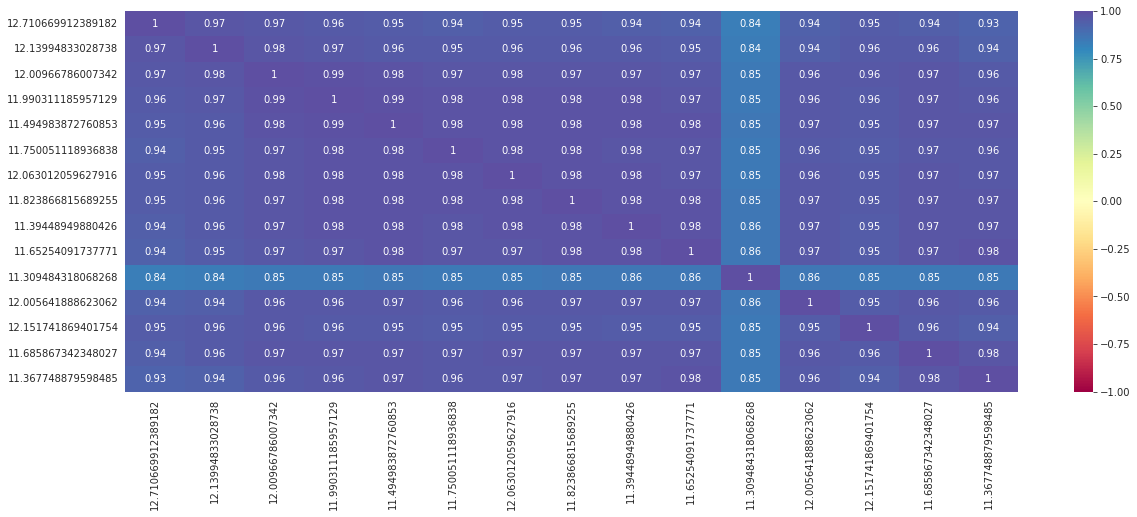

In [43]:
plt.figure(figsize = (20,7))
sns.heatmap(all_trn_preds.corr(), vmin=-1,vmax=1,cmap='Spectral',annot=True)
plt.show()

In [44]:
CALIBRATION=='ridge'
if CALIBRATION == "linear":
    lin_model = LinearRegression()
elif CALIBRATION=='ridge': 
    lin_model = Ridge(alpha=2)

X = all_trn_preds#.iloc[:,:1]
OOF_val_scores_lin = []
OOF_trn_lin= []

OOF_val_lin=  pd.DataFrame(0, index = y.index , columns =[col for col in range(NUM_SPLITS*NUM_FOLDS)])

for fold, (train_idx,val_idx) in enumerate(kfold.split(X,y)):
    X_train,y_train = X.iloc[train_idx,:], y.iloc[train_idx]
    X_test,y_test = X.iloc[val_idx,:], y.iloc[val_idx]
    
    test_preds_lin, trn_preds_lin, val_preds_lin, score_trn_lin, score_val_lin , model_out= base_model(X_train,y_train,X_test,y_test, "ridge",lin_model, X, all_tst_preds, False)
    
    OOF_val_lin.loc[val_idx, fold] = OOF_val_lin.loc[val_idx, fold] + val_preds_lin/NUM_SPLITS
    
    OOF_val_scores_lin.append(score_val_lin)
    OOF_trn_lin.append(trn_preds_lin)
    
#cal_score = np.mean(OOF_val_scores_lin)
cal_score = mean_squared_error(y,OOF_val_lin.sum(axis =1))**0.5
cal_trn_preds  = np.mean(OOF_trn_lin,axis=0)
print(f"Mean RSME(Calibration): {cal_score:.4f}")

Mean RSME(Calibration): 10.0505


In [45]:
#fit on full data 
lin_model.fit(all_trn_preds, np.ravel(y)) # all_trn_preds
y_cal_test  = lin_model.predict(all_tst_preds)

full_fit_RSME = mean_squared_error(y, lin_model.predict(all_trn_preds))**0.5

print(f"Full fit RSME (Calibration): {full_fit_RSME:.4f}")

sub_cal = sub.copy(deep = True)
sub_cal[target] = y_cal_test
sub_cal.to_csv(f"sub_cal_{cal_score:.4f}.csv")
sub_cal.head()

Full fit RSME (Calibration): 9.8435


,Strength
id,
5407,45.928192
5408,28.809921
5409,28.489862
5410,46.084206
5411,23.621128


## Optimize Ensemble

In [46]:
from scipy import optimize
from functools import partial

opt = OptimizedEnsemble()
opt.fit(all_trn_preds,y)
coef = opt.coef_['x']
coef

array([2.98360956e-21, 2.09500494e-17, 3.09754867e-17, 1.40516202e-17,
       5.66924409e-17, 1.77730060e-07, 4.38075151e-21, 3.80984895e-18,
       2.20892996e-06, 2.41195724e-01, 4.19509729e-18, 2.54455392e-17,
       5.10123839e-17, 5.28279535e-03, 7.53519094e-01])

In [47]:
opt_ensemble = opt.predict(all_trn_preds,opt.coef_['x'])
opt_score = mean_squared_error(y,opt_ensemble)**0.5
print(f"Mean RSME Opt: {opt_score:.4f}")

sub_opt = sub.copy(deep = True)
sub_opt[target] = opt.predict(all_tst_preds,opt.coef_['x'])
sub_opt.to_csv(f"sub_opt_{opt_score:.4f}.csv")
sub_opt.head()

Mean RSME Opt: 9.9029


,Strength
id,
5407,46.418582
5408,26.891713
5409,29.086281
5410,46.769835
5411,24.586787


# 🔎 Model Analysis (Partial Dependecy Plots) 🔎
* Partial dependency plots will help us understand how each feature behaves. The process tries to change the value of the selected feature and monitors the models predicted output 

In [48]:
# from pdpbox import pdp, get_dataset, info_plots
# pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test
#                            , model_features=X.columns
#                            , feature="squareMeters")
# pdp.pdp_plot(pdp_dist, feature_name="squareMeters",figsize =(25,7))
# plt.tight_layout()
# plt.show()

In [49]:
# pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test_s
#                            , model_features=X.columns
#                            , feature="sym_1")
# pdp.pdp_plot(pdp_dist, feature_name="sym_1",figsize =(25,7))
# plt.tight_layout()
# plt.show()

# 🧨 Feature Importance 🧨

In [50]:
if name not in ["LinearRegression",'Ridge', "SVR", "nn"]:
    feature_importance = feature_importance.sort_values(by= "Importance", ascending = False)
    plt.figure(figsize = (20,12))
    sns.barplot(x = feature_importance["Importance"], y= feature_importance.index)
    plt.show()

In [51]:
if name not in ["LinearRegression",'Ridge', "SVR", "nn"]:
    print([col for col in feature_importance[feature_importance["Importance"]==0].index])

## Analyse Residuals 
Lets look at what incorrect predictions our model made

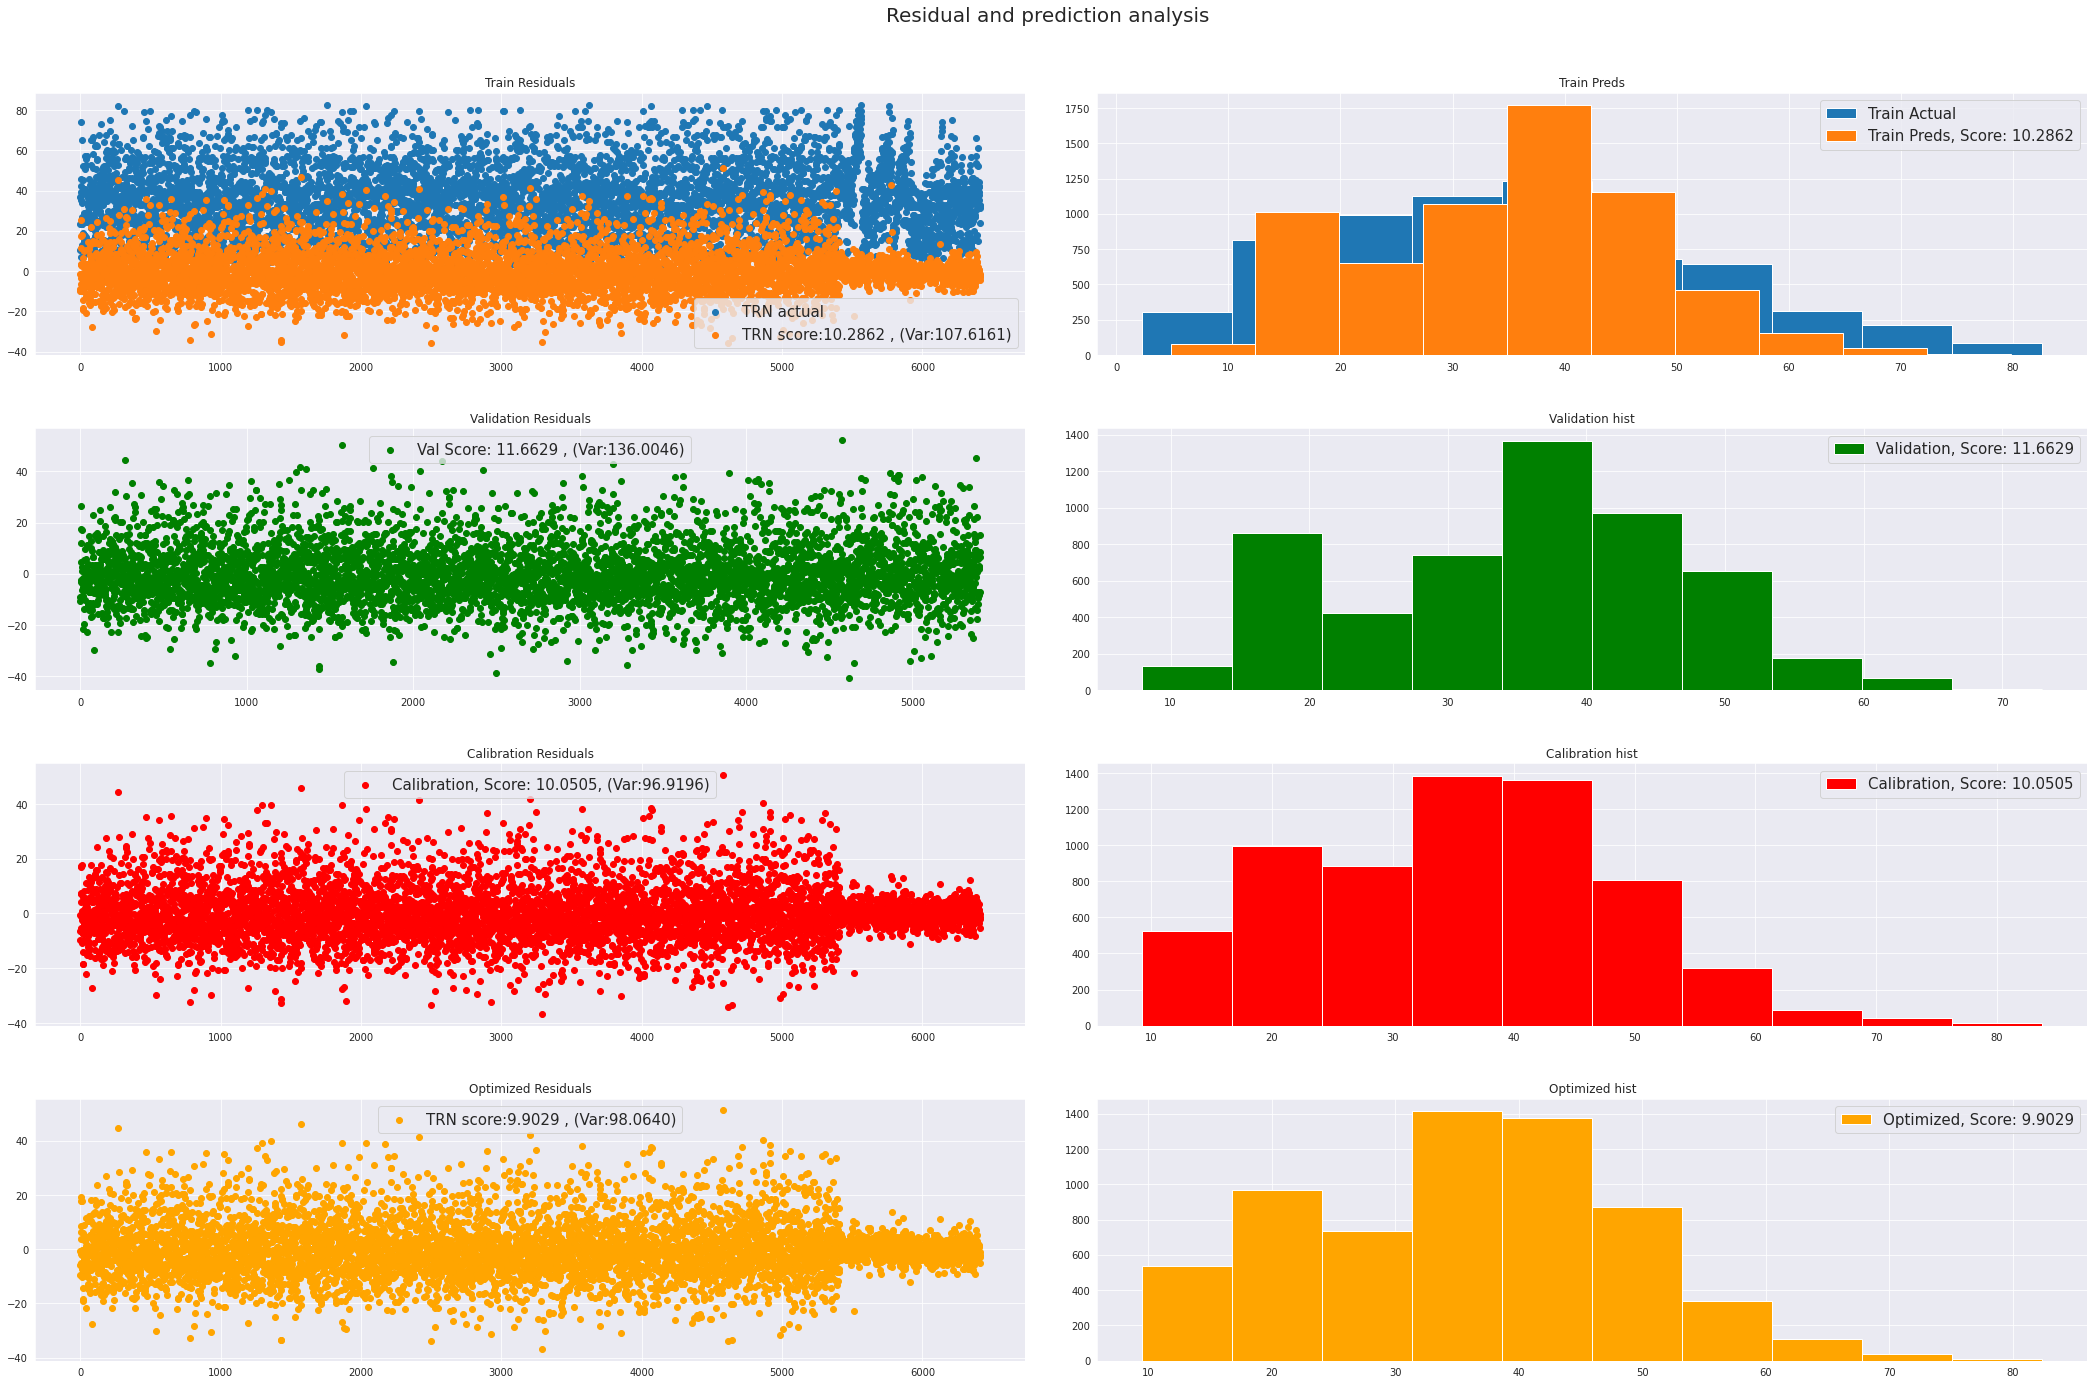

In [52]:
fig, ax = plt.subplots(4,2, figsize = (30,20),sharey = False)
ax = np.ravel(ax)

ax[0].scatter(x = [i for i in range(len(df_trn))], y = df_trn[target],label = f"TRN actual")
ax[0].set_title("Train Actual", fontsize = 12)
ax[1].set_title("Train hist", fontsize = 12)
ax[1].hist(df_trn[target], label = f"Train Actual")

res_trn = y.values- all_train_preds.mean(axis=1)
ax[0].scatter(x = [i for i in range(len(res_trn))], y = res_trn ,label = f"TRN score:{weighted_score:.4f} , (Var:{np.var(res_trn):.4f})")
ax[0].set_title("Train Residuals", fontsize = 12)
ax[1].set_title("Train Preds", fontsize = 12)
ax[1].hist(all_train_preds.mean(axis=1), label = f"Train Preds, Score: {weighted_score:.4f}")

if TEST_ON_GENERATED_ONLY:
    res_val = y[df_trn[df_trn["is_generated"]==1].index].values - val_preds.sum(axis =1)
else:
    res_val = y.values - val_preds.sum(axis =1)
ax[2].scatter(x = [i for i in range(len(res_val))], y = res_val, label = f"Val Score: {val_score:.4f} , (Var:{np.var(res_val):.4f})" ,color ="g")
ax[2].set_title("Validation Residuals", fontsize = 12)
ax[3].set_title("Validation hist", fontsize = 12)
ax[3].hist(val_preds.sum(axis =1), label = f"Validation, Score: {val_score:.4f}",color ="g")

res_cal = y -cal_trn_preds
ax[4].scatter(x = [i for i in range(len(res_cal))], y = res_cal, label = f"Calibration, Score: {cal_score:.4f}, (Var:{np.var(res_cal):.4f})", color = "r")
ax[4].set_title("Calibration Residuals", fontsize = 12)
ax[5].set_title("Calibration hist", fontsize = 12)
ax[5].hist(cal_trn_preds, label = f"Calibration, Score: {cal_score:.4f}", color = "r")

res_opt = y.values- opt_ensemble.values
ax[6].scatter(x = [i for i in range(len(res_opt))], y = res_opt ,label = f"TRN score:{opt_score:.4f} , (Var:{np.var(res_opt):.4f})", color ="orange")
ax[6].set_title("Optimized Residuals", fontsize = 12)
ax[7].set_title("Optimized hist", fontsize = 12)
ax[7].hist(opt_ensemble.values, label = f"Optimized, Score: {opt_score:.4f}", color ="orange")

fig.suptitle("Residual and prediction analysis", fontsize = 20)

ax[0].legend(fontsize= 15)
ax[1].legend(fontsize= 15)
ax[2].legend(fontsize= 15)
ax[3].legend(fontsize= 15)
ax[4].legend(fontsize= 15)
ax[5].legend(fontsize= 15)
ax[6].legend(fontsize= 15)
ax[7].legend(fontsize= 15)
plt.tight_layout(pad =4)
plt.show()

## Analyse Outliers

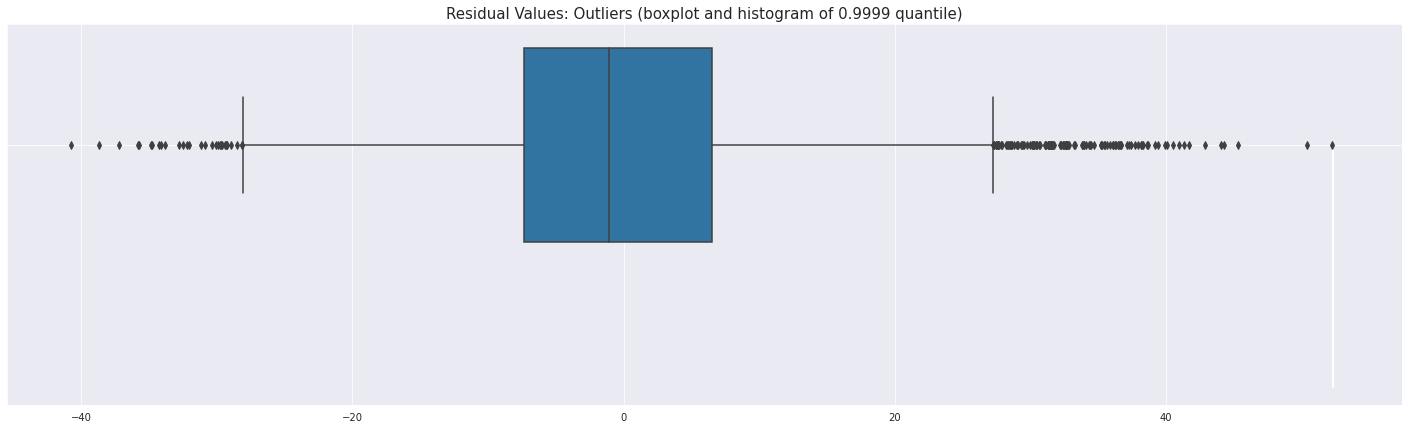

In [53]:
plt.figure(figsize = (25,7))
sns.boxplot(res_val)
res_val[(res_val>res_val.quantile(0.9999)) | (res_val<-res_val.quantile(0.9999))].hist(bins =20)
plt.title("Residual Values: Outliers (boxplot and histogram of 0.9999 quantile)", fontsize = 15)
plt.show()

In [54]:
df_trn.describe()

,CementComponent,BlastFurnaceSlag,FlyAshComponent,WaterComponent,SuperplasticizerComponent,CoarseAggregateComponent,FineAggregateComponent,AgeInDays,Strength,is_generated,CementComponent_grp_mean,BlastFurnaceSlag_grp_mean,FlyAshComponent_grp_mean,WaterComponent_grp_mean,SuperplasticizerComponent_grp_mean,CoarseAggregateComponent_grp_mean,FineAggregateComponent_grp_mean,AgeInDays_grp_mean
count,6412.000000,6412.000000,6412.000000,6412.000000,6412.000000,6412.000000,6412.000000,6412.000000,6412.000000,6412.000000,6412.000000,6412.000000,6412.000000,6412.000000,6412.000000,6412.000000,6412.000000,6412.000000
mean,295.949298,60.716017,35.581753,184.605880,4.410128,989.238394,771.450109,50.827667,35.420459,0.843263,36.306190,17.098471,11.957390,36.008212,18.595008,36.412123,35.894865,35.301115
std,105.607727,83.990553,56.867776,19.017117,5.770698,77.475194,78.976065,69.090046,16.382499,0.363581,8.591640,20.811450,19.113070,7.740039,21.760475,7.845685,8.166001,10.775522
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,2.330000,0.000000,15.295000,0.000000,0.000000,0.000000,0.000000,13.460000,13.460000,6.270000
25%,212.500000,0.000000,0.000000,173.500000,0.000000,938.000000,734.300000,7.000000,23.640000,1.000000,30.676000,0.000000,0.000000,30.644892,0.000000,30.657895,30.264828,22.846047
50%,295.800000,0.000000,0.000000,186.000000,0.000000,975.600000,781.000000,28.000000,33.945000,1.000000,34.526966,0.000000,0.000000,34.377111,0.000000,35.993077,35.714167,37.397488
75%,374.000000,129.800000,94.025000,192.000000,8.700000,1047.000000,821.000000,56.000000,45.710000,1.000000,40.390000,36.848462,29.818333,39.940000,39.205000,40.891667,40.425000,41.315028
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.600000,1.000000,74.700000,74.700000,66.900000,66.900000,65.910000,66.900000,74.700000,62.210313


# 🟧 Shap Values 🟧
* Shap values are a great way to visualise how our model processed these new features

In [55]:
shap.initjs() # for visualization 

NB we are working with the shap values for on the test data. so the shap values might be wrong (as would they be for any validation) 

In [56]:
if SHAP_VALS:
    folds = NUM_SPLITS* NUM_FOLDS
    shap_values_cv = np.abs(shap_values[0])/folds

    #get shap values (from all folds)
    for i  in range(1,len(shap_values)):
        shap_values_cv = shap_values_cv +(np.abs(shap_values[i]))/folds

In [57]:
if SHAP_VALS:
    fig = plt.figure()
    ax0 = fig.add_subplot(121)
    shap.summary_plot(shap_values_cv, df_tst,max_display = 4000, plot_size = [30,20], show= False)
    ax1 = fig.add_subplot(122)
    shap.summary_plot(shap_values_cv, df_tst,max_display = 4000, plot_size = [30,20], show= False, plot_type="bar")
    plt.gcf().set_size_inches(30,10)
    fig.suptitle("Average Shap values for all samples",fontsize = 20)
    ax0.title.set_text("Shap Summary")
    ax1.title.set_text("Shap bar plot (magnitide)")
    plt.tight_layout() 
    plt.show()

### Dependecy plots

In [58]:
if SHAP_VALS:
    fig = plt.figure()
    ax0 = fig.add_subplot(1,2,1)
    shap.dependence_plot("AgeInDays", shap_values_cv, df_tst, display_features=df_tst, interaction_index="CementComponent", show=False,ax= ax0)
    ax0.set_title("AgeInDays vs CementComponent" )
    ax1 = fig.add_subplot(1,2,2)
    shap.dependence_plot("SuperplasticizerComponent", shap_values_cv, df_tst, display_features=df_tst, interaction_index="CementComponent", show=False,ax= ax1)
    ax0.set_title("SuperplasticizerComponent vs CementComponent" )
    plt.gcf().set_size_inches(25,7)
    plt.tight_layout()
    plt.show()

### Approximate interactions 
The below are approximate interaction values, a full visualization of interaction between columns requires  shapley interaction_values (see below)

In [59]:
if SHAP_VALS:
    # select amd interaction column
    inds = shap.approximate_interactions("CementComponent", shap_values_cv, df_tst)

    fig = plt.figure()
    for i in range(1,4):
        axes = fig.add_subplot(1,3,i)
        shap.dependence_plot("CementComponent", shap_values_cv, df_tst, display_features=df_tst, interaction_index=inds[i-1], ax= axes, show= False)
    plt.gcf().set_size_inches(30,8)
    plt.show()

### Shap interaction values
* The interaction plots help us understand how our each feature "interacts" with the others with respect to our models predictio
* I have excluded interaction value as it uses too much memory to concatenate all the values from the CV (however we can do this for one model if needed)

In [60]:
if SHAP_VALS:
    folds = NUM_SPLITS* NUM_FOLDS
    shap_interactions_cv = np.abs(shap_interactions[0])/folds

    #get shap values (from all folds)
    for i  in range(1,len(shap_values)):
        shap_interactions_cv = shap_interactions_cv +(np.abs(shap_interactions[i]))/folds
        
    shap.summary_plot(shap_interactions_cv, df_tst,  show=False, max_display = 5)
    plt.gcf().set_size_inches(30,10)
    plt.show()

In [61]:
if SHAP_VALS:
    fig,ax = plt.subplots(figsize = (20, 12)) 
    # Get absolute mean of shap values nad put in dataframe
    abs_mean_shap = pd.DataFrame(np.abs(shap_interactions_cv).mean(axis =0), index=df_tst.columns, columns=df_tst.columns)
    df = pd.DataFrame(abs_mean_shap, columns=df_tst.columns)
    df.where(df.values == np.diagonal(df),df.values*2, inplace=True)

    # upper_triangle = np.triu(np.ones_like(corr, dtype=bool))
    sns.heatmap(df, cmap='coolwarm', annot=True, fmt='.6g', cbar=True )

    ax.tick_params(axis='x', labelsize=10, rotation=90)
    ax.tick_params(axis='y',  labelsize=10)
    plt.suptitle("Absolute Mean Shap Interaction Values (Magnitude of effect on model predictions)",fontsize=15)
    plt.tight_layout(pad = 4)
    plt.show()

# Save

In [62]:
pd.DataFrame(np.mean(test_preds,axis =0)).to_csv(f"test_preds_{name}.csv")
val_preds.sum(axis=1).to_csv(f"val_preds_{name}.csv")

# Score

In [63]:
print(f"OOF TRN Score: {np.mean(OOF_trn_score,axis =0):.4f}")
print(f"OOF val Score: {val_score:.4f}")
print(f"Weighted Score: {weighted_score:.4f}")
print(f"Optimized Score: {opt_score:.4f}")
print(f"Calibrated Score val: {cal_score:.4f}, trn :{full_fit_RSME:.4f}")

OOF TRN Score: 10.7338
OOF val Score: 11.6629
Weighted Score: 10.2862
Optimized Score: 9.9029
Calibrated Score val: 10.0505, trn :9.8435


epochs = 10
* OOF TRN Score: 10.5634
* OOF val Score: 11.7557
* Weighted Score: 10.2095
* Optimized Score: 9.7786
* Calibrated Score val: 9.9717, trn :9.7244